# Gun Control and Crime

## Introduction

Gun control and gun violance is a hot topic in american politics. Often you will here loud and emotional arguments on TV about assault rile bans and similiar issues. While people aligning with the democartic party usually assume that more gun ownership will lead to more murders, conservatives usually cite the slogan "only a good guy with a gun will stop a bad guy with a gun". In my final tutorial I will analize crime data from the year 2013 to try and determine if the rate of gun ownership in a state is correlated to the murder rate.

A lot of other analyses of this type of data take a slightly different approach. For example a Vox documentary (https://www.youtube.com/watch?v=bX4qUsgHa4Y) looks at gun deaths and gun ownership. I believe that is problematic, because it includes gun related deaths which may be tragic, but are very different from murders. For example that number includes people shot by the police of ordinary citizens in self defense and suicides. Don't get me wrong: These are tragic events, but they should not be put in the same spotlight as murder. The murder rate I use also includes other types of murders (e.g. with knives). The reason for this is that, in the presence of guns a lot of murders which may otherwise be committed by knives will be committed with guns. This would be observable by an increase in gun murders. But as this effect would lead to a decrease in knife murders, and all murders are equally bad, it is only reasonable to look at how the total number of murders is affected by gun ownership. Also doing it this way will include effects such as knife murders prevented by a law abiding citizen defending himself with a gun.

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
import pandas as pd
import scipy.stats

## The Data

Multiple data sources had to be combined to reach the final conclusions.

Crime data from the FBI's uniform crime reports are used for data on the amount of murders and nonnegligent manslaughters (https://www.ucrdatatool.gov/Search/Crime/Crime.cfm). Since we need the amount of murders per capita instead of just total number, also population data by state is needed. This data comes from the US Census Bureau's 2017 estimate of the 2013 US population by state (https://www.census.gov/data/tables/2017/demo/popest/nation-total.html). The gun ownership data is from a study conducted by Bindu Kalesan, et al (https://injuryprevention.bmj.com/content/injuryprev/early/2015/06/09/injuryprev-2015-041586.full.pdf?keytype=ref&ijkey=doj6vx0laFZMsQ2). The sample in the study were 4000 US adults.

### Crime Data

In [2]:
f = open("./crime_data.csv")
lines = f.readlines()
f.close()

In [3]:
states_lst= lines[4].split(",")[1:]
states = []
murders = []
years = []

for line in lines[5:60]:
    if line == "\n":
        continue
    line_split = line.split(",")
    
    year = int(line_split[0])
    
    if not year == 2013:
        continue
    
    for i, a in enumerate(line_split[1:]):
        years.append(year)
        states.append(states_lst[i])
        
        if a == "" or a == "\n":
            murders.append(float("nan"))
        else:
            murders.append(float(a))
    
    ###########

### Census Data

In [4]:
f = open("./population_data.csv")
lines = f.readlines()
f.close()

In [5]:
years_pop_lst = [int(float(x)) for x in lines[0].split(",")[4:-6]]
population = []
states_pop = []
years_pop = []

for i, line in enumerate(lines[1:]):
    state = states_lst[i]
    for j, a in enumerate(line.split(",")[4:-6]):
        years_pop.append(years_pop_lst[j])
        states_pop.append(states_lst[i])
        population.append(int(float(a)))

### Gun Ownership Data

In [6]:
gun_ownership = [48.9, 61.7, 32.3, 57.9, 20.1, 34.3, 16.6, 5.2, 25.9, 32.5, 31.6, 45.1, 56.9, 26.2, 33.8, 33.8, 32.2, 42.4, 44.5, 22.6, 20.7, 22.6, 28.8, 36.7, 42.8, 27.1, 52.3, 19.8, 37.5, 14.4, 11.3, 49.9, 10.3, 28.7, 47.9, 19.6, 31.2, 26.6, 27.1, 5.8, 44.4, 35.0, 39.4, 35.7, 31.9, 28.8, 29.3, 27.7, 54.2, 34.7, 53.8, 29.1]

### Pandas DataFrame

In [7]:
data = pd.DataFrame(data={"year": years, "state": states, "population": population, "murders": murders, "gun_ownership": gun_ownership})

In [8]:
data.head()

,gun_ownership,murders,population,state,year
0,48.9,346.0,4827660,Alabama,2013
1,61.7,34.0,736760,Alaska,2013
2,32.3,355.0,6616124,Arizona,2013
3,57.9,158.0,2956780,Arkansas,2013
4,20.1,1746.0,38347383,California,2013


The murder rate per 100,000 can be calculated by:
\begin{equation}
\text{murder rate} = \frac {\text{#murders} \times 100,000}{population}
\end{equation}

In [9]:
data["murder_rate"] = data["murders"] / data["population"] * 100000

In [10]:
data.head()

,gun_ownership,murders,population,state,year,murder_rate
0,48.9,346.0,4827660,Alabama,2013,7.167033
1,61.7,34.0,736760,Alaska,2013,4.614800
2,32.3,355.0,6616124,Arizona,2013,5.365679
3,57.9,158.0,2956780,Arkansas,2013,5.343651
4,20.1,1746.0,38347383,California,2013,4.553114


# Analysis

## Exploratory

To just look at the data, I am plotting the murder rate against the gun ownership rate.

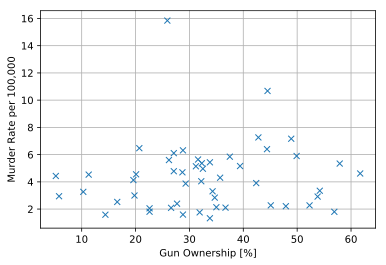

In [11]:
x = data["gun_ownership"][:-1]
y = data["murder_rate"][:-1]

plt.plot(x, y, "x")

plt.xlabel("Gun Ownership [%]")
plt.ylabel("Murder Rate per 100,000")

plt.grid()
plt.show()

Looking at the above figure, there does not immediatly appear to be a correlation. It is also interesting to note some outliers. Firstly, the District of Columbia has a murder rate of almost 16. It does not however have a particularly high amount of gun owners. It is propably related to the fact that if in contrast to the other states (yes I know DC is not a state) is just an urban area. Another interesting state is Idaho with a murder rate of only 1.8 but a gun ownership rate of 56.9 %.

## Is gun ownership correlated to murder rate?

Is there a realtion between gun ownership and murder rate? In this section I will try to find an answer to that question. First by just performing a linear regression, than using hypothesis testing.

### Linear Regression

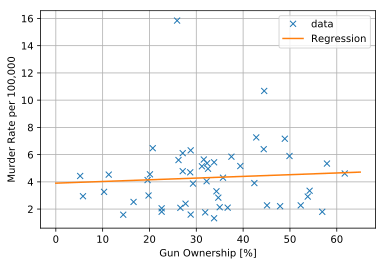

In [12]:
regression = np.poly1d(np.polyfit(x, y, 1))

plt.plot(x, y, "x", label="data")
x_ = np.linspace(0, 65, 2)
plt.plot(x_, regression(x_), label="Regression")

plt.xlabel("Gun Ownership [%]")
plt.ylabel("Murder Rate per 100,000")

plt.grid()
plt.legend()
plt.show()

As can be seen above, the linear regression line does have a positive slope, although it appears to be small compared to the overall variation in murder rate.

### Hypothesis Testing

To finally answer the question, I will assume that the null hypothesis is no relation (slope=0) between the two variables

Scipy's linear regression will give all needed information:

In [13]:
scipy.stats.linregress(x, y)

LinregressResult(slope=0.012489883846117102, intercept=3.904170616296212, rvalue=0.066972803365926578, pvalue=0.64053623100372714, stderr=0.026581880894526323)

The most important number to look at above is the pvalue=0.64. The p-value given by scipy is the two-sided p-value. This means assuming the null hypothesis is true (slope=0) there is about a 64% chance to observe a solpe as extrem (both positive and negative) as the one observed here. So there is not enough in the data to conclude that gun ownership and murder rate are related (using 95%-confidence). Not even a 1-sigma test would reject the null hypothesis.

# Does Permissive Open Carry Reduce the Number of Murder?

In [14]:
permissive_open_carry = [True, True, True, True, False, False, False, True, False, False, False, False, True, False, False, False, True, True, True, True, False, False, True, False, True, False, True, False, True, True, False, True, False, True, False, True, False, False, False, False, False, True, False, False, False, True, True, True, True, True, True]

2 2


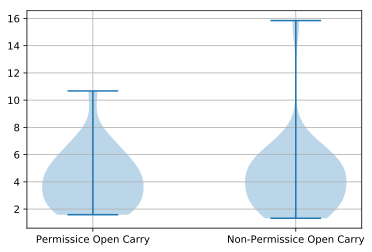

In [15]:
violin_x = [0, 1]
violin_y = []

violin_false = []
violin_true = []
for i in data.index[:-1]:
    if permissive_open_carry[i] == True:
        violin_true.append(data["murder_rate"].iloc[i])
    else:
        violin_false.append(data["murder_rate"].iloc[i])

print(len(violin_x), len([violin_true, violin_false]))

plt.violinplot([violin_true, violin_false], [0, 1])
plt.xticks([0.0, 1.0], ["Permissice Open Carry", "Non-Permissice Open Carry"])
plt.grid()

As can be seen in the violin-plot above disallowing permissive open carry does not have a meaningful effect on the murder rate.